# AOS AuxTel: update out-of-focus  WCS exposures using astrometric fitting of the in-focus exposure

Summary: 

   * the initial WCS in inspected auxTel images was off by ~180 degrees. Even after accounting for that it was ~100px off. 
   * we use a triad of images: in-focus, extra-focal, and intra-focal
   * we run `SourceDetectionTask` to detect position of sources  on the in-focus exposure
   * we  load reference catalog objects from the location given by ra,dec, rotation angle  with `ts_wep` `RefCatalogInterface`
   * we cross-match the detected sources catalog against reference catalog to correct the WCS  with `AstrometryTask`
   * we update the out-of-focus exposures with new WCS 
   * we run `ts_wep` `EstimateZernikesLatissTask` to estimate Zernikes based on the intra-focal and extra-focal images
   * we plot the resulting Zernike estimates and donut cutout stamps. All results are saved as a numpy pickle.
    

Technical details:
 * run on `lsst-devl02` with `w_2021_43` of the `lsst_distrib`
 * using `ts_wep` on `tickets/DM-31655` branch, rebased against `develop` 
 * last verified to run: `2021-10-28` 
 

First , test PSF kernels with different l - how does it affect everything ? 

In [35]:
%matplotlib inline
from lsst.pipe.tasks.characterizeImage import CharacterizeImageTask, CharacterizeImageConfig
from lsst.daf import butler as dafButler
import numpy as np
import yaml
import matplotlib.pyplot as plt
from copy import deepcopy
from copy import copy
from astropy.io import fits
from astropy.visualization import ZScaleInterval
import astropy.units as u

import lsst.utils.tests
import lsst.geom
import lsst.afw.geom as afwGeom
from lsst.afw.geom import makeSkyWcs,  makeCdMatrix
import lsst.afw.table as afwTable
import lsst.afw.image as afwImage
from lsst.afw.image.utils import defineFilter
from lsst.afw.image import FilterLabel
import lsst.afw.display as afwDisplay
import lsst.meas.base as measBase

from lsst.meas.algorithms import LoadIndexedReferenceObjectsTask, MagnitudeLimit
from lsst.meas.algorithms.detection import SourceDetectionTask

from lsst.meas.astrom import AstrometryTask

from lsst.ts.wep.task.RefCatalogInterface import RefCatalogInterface
from lsst.ts.wep.task.GenerateDonutCatalogWcsTask import (GenerateDonutCatalogWcsTask, 
                                                          GenerateDonutCatalogWcsTaskConfig)

from lsst.ts.wep.task.EstimateZernikesLatissTask import (EstimateZernikesLatissTask, 
                                                         EstimateZernikesLatissTaskConfig)

from lsst.ts.wep.Utility import DefocalType
from lsst.ts.wep.DonutDetector import DonutDetector

year='2021'
monthDay='0908'
expIntra=487
expExtra=488
expFocus=489

# 1) Read in the extra, intra, and in-focus exposures: 
butler = dafButler.Butler('/repo/main/', instrument='LATISS')


exposure_intra = butler.get('postISRCCD', dataId={'instrument':'LATISS', 'detector':0, 
                                     'exposure':int(f'{year}{monthDay}00{expIntra}')},
                      collections=['u/scichris/Latiss/postISRtest'])

exposure_extra = butler.get('postISRCCD', dataId={'instrument':'LATISS', 'detector':0, 
                                     'exposure':int(f'{year}{monthDay}00{expExtra}')},
                      collections=['u/scichris/Latiss/postISRtest'])

postIsr = butler.get('postISRCCD', dataId={'instrument':'LATISS', 'detector':0, 
                                     'exposure':int(f'{year}{monthDay}00{expFocus}')},
                      collections=['u/scichris/Latiss/postISRtest'])

#2) Use the in-focus image to do source detection, and  do astrometry matching against  
# a reference catalog to obtain an updated WCS


# Define the PSF to fit: 
def gkern(l=3, sig=0.5):
    """
    creates gaussian kernel with side length l and a sigma of sig
    """

    ax = np.linspace(-(l - 1) / 2., (l - 1) / 2., l)
    xx, yy = np.meshgrid(ax, ax)

    kernel = np.exp(-0.5 * (np.square(xx) + np.square(yy)) / np.square(sig))

    return kernel / np.sum(kernel)
#Run detection and measure on the correlated image using the simple PSF
psf_array = gkern(l=11, sig=2.5)
# #psf_array = gkern(l=5, sig=0.5)
psf_array = psf_array.astype(np.float64)
psf_image = lsst.afw.image.ImageD(psf_array)
psf_kernel = lsst.afw.math.FixedKernel(psf_image)
psf = lsst.meas.algorithms.KernelPsf(psf_kernel)

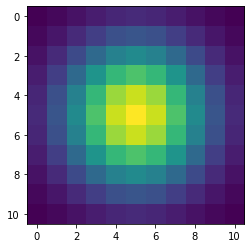

In [38]:
plt.imshow(psf_image.array)

#### Aside: tryiung to run the repair task 

Make a defect list to figure out which part of the image is problematic to the algorithm...Following the example in 
https://github.com/lsst/pipe_tasks/blob/387f8f07a2b66205f9fa6bda9a89dcdbbef3f64c/examples/runRepair.py#L59

In [43]:
import lsst.meas.algorithms as measAlg
img = postIsr.getMaskedImage().getImage()
(xsize,ysize) = img.getDimensions()
#defectList = measAlg.Defect()

In [ ]:
import

In [45]:
import lsst.geom as geom
bbox = geom.Box2I(geom.PointI(0,ysize-400), geom.ExtentI(400,400))
subIm = afwImage.ImageF(img, bbox)

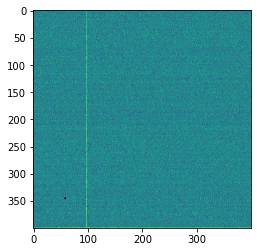

In [51]:
from astropy.visualization import ZScaleInterval
zscale = ZScaleInterval()
data = subIm.array
vmin,vmax = zscale.get_limits(data)
plt.imshow(subIm.array, vmin=vmin, vmax=vmax)

In [62]:
mask = postIsr.getMask()

In [64]:
np.unique(mask.array)

array([  0,   4,   6, 256, 262], dtype=int32)

In [65]:
mask

lsst.afw.image.image.MaskX=[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [4 4 4 ... 0 0 0]
 [4 4 4 ... 0 0 0]
 [4 4 4 ... 0 0 0]], bbox=(minimum=(0, 0), maximum=(4071, 3999)), maskPlaneDict={'BAD': 0, 'CR': 3, 'DETECTED': 5, 'DETECTED_NEGATIVE': 6, 'EDGE': 4, 'INTRP': 2, 'NO_DATA': 8, 'SAT': 1, 'SUSPECT': 7, 'UNMASKEDNAN': 9}

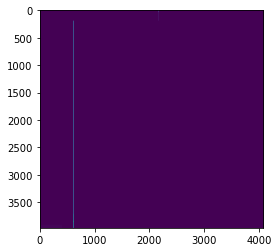

In [72]:
plt.imshow(mask.array[np.where(mask.array == 256)[0]])

I follow how defect list shoud be made https://github.com/lsst/meas_algorithms/blob/9283e855e2f883fa5da6fc3602cbd30621686d44/python/lsst/meas/algorithms/testUtils.py#L150 

In [54]:
defectList =  [measAlg.Defect(bbox)]

In [56]:
from lsst.pipe.tasks.repair import RepairTask
repair = RepairTask(name="RepairTask")
postIsr.setPsf(psf)
repair.run(postIsr, defects=defectList)# , defects=defectList)

LengthError: 
  File "src/CR.cc", line 409, in std::vector<std::shared_ptr<lsst::afw::detection::Footprint> > lsst::meas::algorithms::findCosmicRays(MaskedImageT&, const lsst::afw::detection::Psf&, double, const lsst::daf::base::PropertySet&, bool) [with MaskedImageT = lsst::afw::image::MaskedImage<float>]
    Too many CR pixels (max 10000) {0}
lsst::pex::exceptions::LengthError: 'Too many CR pixels (max 10000)'


In [ ]:
img = exp.getMaskedImage().getImage()
(xsize, ysize) = img.getDimensions()
defectList = measAlg.Defects()

# set some bad cols and add them to a defect list
for xi in numpy.random.randint(0, xsize, nBadCols):
    yi = numpy.random.randint(0, ysize)
    xi, yi = int(xi), int(yi)
    bbox = geom.Box2I(geom.PointI(xi, 0), geom.ExtentI(1, yi+1))
    subIm = afwImage.ImageF(img, bbox)
    subIm.set(1e7)
    defectList.append(bbox)
# set a 15 pixel box of defects at the upper left corner to demonstrate fallbackValue
bbox = geom.Box2I(geom.PointI(0, ysize-15), geom.ExtentI(15, 15))
subIm = afwImage.ImageF(img, bbox)
subIm.set(1e7)
defectList.append(bbox)

### Running source detection

In [74]:
from lsst.meas.algorithms.installGaussianPsf import InstallGaussianPsfTask

installPsfTask = InstallGaussianPsfTask()
installPsfTask.run(postIsr)

/software/lsstsw/stack_20210813/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/meas_algorithms/22.0.1-29-g401bd7c4+b21ea61266/python/lsst/meas/algorithms/installGaussianPsf.py:77: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  psfSigma = psfModel.computeShape().getDeterminantRadius()
/software/lsstsw/stack_20210813/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/meas_algorithms/22.0.1-29-g401bd7c4+b21ea61266/python/lsst/meas/algorithms/installGaussianPsf.py:78: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  width, height = psfModel.computeImage().getDimensions()


Get the `postIsr` and set the PSF manually : 

In [124]:
# try another test data...
monthDay='0707'
expFocus = 462
postIsr = butler.get('postISRCCD', dataId={'instrument':'LATISS', 'detector':0, 
                                     'exposure':int(f'{year}{monthDay}00{expFocus}')},
                      collections=['u/scichris/Latiss/postISRtest'])

#2) Use the in-focus image to do source detection, and  do astrometry matching against  
# a reference catalog to obtain an updated WCS


# Define the PSF to fit: 
def gkern(l=3, sig=0.5):
    """
    creates gaussian kernel with side length l and a sigma of sig
    """

    ax = np.linspace(-(l - 1) / 2., (l - 1) / 2., l)
    xx, yy = np.meshgrid(ax, ax)

    kernel = np.exp(-0.5 * (np.square(xx) + np.square(yy)) / np.square(sig))

    return kernel / np.sum(kernel)
#Run detection and measure on the correlated image using the simple PSF
psf_array = gkern(l=11, sig=2.5)
# #psf_array = gkern(l=5, sig=0.5)
psf_array = psf_array.astype(np.float64)
psf_image = lsst.afw.image.ImageD(psf_array)
psf_kernel = lsst.afw.math.FixedKernel(psf_image)
psf = lsst.meas.algorithms.KernelPsf(psf_kernel)

In [ ]:
plot the exposure 

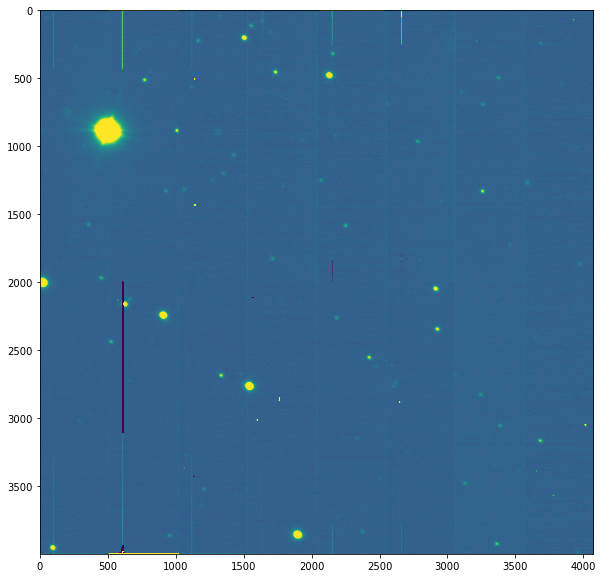

In [125]:
from astropy.visualization import ZScaleInterval
fig = plt.figure(figsize=(10,10))
zscale = ZScaleInterval()
data = postIsr.image.array
vmin,vmax = zscale.get_limits(data)
plt.imshow(data, vmin=vmin, vmax=vmax)

In [126]:
print(vmin,vmax)

-9.348323 86.3094294988427


In [139]:
# Run source detection:
# Use DM tasks to run: detection, measure using the simple PSF (no deblending)
schema = lsst.afw.table.SourceTable.makeMinimalSchema()

# setup source detection configuration
configDetection = SourceDetectionTask.ConfigClass()
configDetection.thresholdValue = 3 #  # detection threshold in units of thresholdType
configDetection.thresholdType = "stdev"  # units for thresholdValue
configDetection.minPixels = 100
#configDetection.includeThresholdMultiplier = 1.0
configDetection.background.weighting=  False#  charImage.background.weighting = False  
detect = lsst.meas.algorithms.SourceDetectionTask(schema=schema, config=configDetection)
measure = lsst.meas.base.SingleFrameMeasurementTask(schema=schema)

In [140]:
# this is really just a factory for records, not a table
table = lsst.afw.table.SourceTable.make(schema)  

#create copy of in-focus image 
exposure = deepcopy(postIsr)
exposure.setPsf(psf)
#postIsr.setPsf(psf)

# Run the source detection the measure tasks
detect_result = detect.run(table, exposure,)# weighing=False)
detected_catalog = detect_result.sources   # this is the actual catalog, but most of it's still empty
measure.run(detected_catalog, exposure)

/software/lsstsw/stack_20210813/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/meas_algorithms/22.0.1-29-g401bd7c4+b21ea61266/python/lsst/meas/algorithms/detection.py:410: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  sigma = psf.computeShape().getDeterminantRadius()
/software/lsstsw/stack_20210813/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/meas_algorithms/22.0.1-29-g401bd7c4+b21ea61266/python/lsst/meas/algorithms/detection.py:447: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  sigma = psf.computeShape().getDeterminantRadius()


TaskError: All pixels masked. Cannot estimate background

In [119]:
detected_catalog

<class 'lsst.afw.table.SourceCatalog'>
 id      coord_ra          coord_dec      ... base_Variance_value base_Variance_flag_emptyFootprint
           rad                rad         ...                                                      
--- ----------------- ------------------- ... ------------------- ---------------------------------
  1 5.387290107780798 -1.5263072505885922 ...                 nan                              True

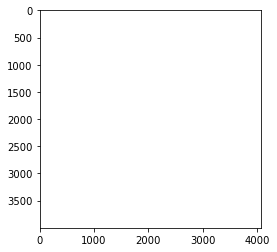

In [102]:
plt.imshow(postIsr.image.array, vmin=200,vmax=1500)

In [101]:
zscale = ZScaleInterval()
data = postIsr.getImage().getArray()
zscale = ZScaleInterval()
vmin, vmax = zscale.get_limits(data)
fig,ax = plt.subplots(figsize=(10,10))
ax.imshow(data, vmin=vmin, vmax=vmax,cmap='Greys', origin='lower')
ax.scatter(detected_catalog['slot_Centroid_x'], detected_catalog['slot_Centroid_y'],
           s=100,facecolors='none', edgecolors='red',)
plt.savefig(f'{year}{monthDay}00{expFocus}_detected.png', bbox_inches='tight')


IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
%matplotlib inline
from lsst.pipe.tasks.characterizeImage import CharacterizeImageTask, CharacterizeImageConfig
from lsst.daf import butler as dafButler
import numpy as np
import yaml
import matplotlib.pyplot as plt
from copy import deepcopy
from copy import copy
from astropy.io import fits
from astropy.visualization import ZScaleInterval
import astropy.units as u

import lsst.utils.tests
import lsst.geom
import lsst.afw.geom as afwGeom
from lsst.afw.geom import makeSkyWcs,  makeCdMatrix
import lsst.afw.table as afwTable
import lsst.afw.image as afwImage
from lsst.afw.image.utils import defineFilter
from lsst.afw.image import FilterLabel
import lsst.afw.display as afwDisplay
import lsst.meas.base as measBase

from lsst.meas.algorithms import LoadIndexedReferenceObjectsTask, MagnitudeLimit
from lsst.meas.algorithms.detection import SourceDetectionTask

from lsst.meas.astrom import AstrometryTask

from lsst.ts.wep.task.RefCatalogInterface import RefCatalogInterface
from lsst.ts.wep.task.GenerateDonutCatalogWcsTask import (GenerateDonutCatalogWcsTask, 
                                                          GenerateDonutCatalogWcsTaskConfig)

from lsst.ts.wep.task.EstimateZernikesLatissTask import (EstimateZernikesLatissTask, 
                                                         EstimateZernikesLatissTaskConfig)

from lsst.ts.wep.Utility import DefocalType
from lsst.ts.wep.DonutDetector import DonutDetector

def fit_zernikes_with_updated_wcs(year='2021', monthDay='0908', 
                                  expIntra=487, expExtra=488, 
                                  expFocus=489):

    # 1) Read in the extra, intra, and in-focus exposures: 
    butler = dafButler.Butler('/repo/main/', instrument='LATISS')


    exposure_intra = butler.get('postISRCCD', dataId={'instrument':'LATISS', 'detector':0, 
                                         'exposure':int(f'{year}{monthDay}00{expIntra}')},
                          collections=['u/scichris/Latiss/postISRtest'])

    exposure_extra = butler.get('postISRCCD', dataId={'instrument':'LATISS', 'detector':0, 
                                         'exposure':int(f'{year}{monthDay}00{expExtra}')},
                          collections=['u/scichris/Latiss/postISRtest'])

    postIsr = butler.get('postISRCCD', dataId={'instrument':'LATISS', 'detector':0, 
                                         'exposure':int(f'{year}{monthDay}00{expFocus}')},
                          collections=['u/scichris/Latiss/postISRtest'])

    #2) Use the in-focus image to do source detection, and  do astrometry matching against  
    # a reference catalog to obtain an updated WCS


    # Define the PSF to fit: 
    def gkern(l=3, sig=0.5):
        """
        creates gaussian kernel with side length l and a sigma of sig
        """

        ax = np.linspace(-(l - 1) / 2., (l - 1) / 2., l)
        xx, yy = np.meshgrid(ax, ax)

        kernel = np.exp(-0.5 * (np.square(xx) + np.square(yy)) / np.square(sig))

        return kernel / np.sum(kernel)
    #Run detection and measure on the correlated image using the simple PSF
    psf_array = gkern(l=11, sig=2.5)
    # #psf_array = gkern(l=5, sig=0.5)
    psf_array = psf_array.astype(np.float64)
    psf_image = lsst.afw.image.ImageD(psf_array)
    psf_kernel = lsst.afw.math.FixedKernel(psf_image)
    psf = lsst.meas.algorithms.KernelPsf(psf_kernel)


    # Run source detection:
    # Use DM tasks to run: detection, measure using the simple PSF (no deblending)
    schema = lsst.afw.table.SourceTable.makeMinimalSchema()

    # setup source detection configuration
    configDetection = SourceDetectionTask.ConfigClass()
    configDetection.thresholdValue = 5 #  # detection threshold in units of thresholdType
    configDetection.thresholdType = "stdev"  # units for thresholdValue
    configDetection.minPixels = 5
    configDetection.includeThresholdMultiplier = 1.0
    #configDetection.charImage.background.weighting = False  
    detect = lsst.meas.algorithms.SourceDetectionTask(schema=schema, config=configDetection)
    measure = lsst.meas.base.SingleFrameMeasurementTask(schema=schema)

    # this is really just a factory for records, not a table
    table = lsst.afw.table.SourceTable.make(schema)  

    #create copy of in-focus image 
    exposure = deepcopy(postIsr)
    exposure.setPsf(psf)

    # Run the source detection the measure tasks
    detect_result = detect.run(table, exposure,)# weighing=False)
    detected_catalog = detect_result.sources   # this is the actual catalog, but most of it's still empty
    measure.run(detected_catalog, exposure)

    # if required, plot the source catalog on top of the postISR exposure to
    # prove that the correct sources were detected - useful
    # for debugging 
    plot_detected_sources = True
    if plot_detected_sources:

        zscale = ZScaleInterval()
        data = exposure.getImage().getArray()
        zscale = ZScaleInterval()
        vmin, vmax = zscale.get_limits(data)
        fig,ax = plt.subplots(figsize=(10,10))
        ax.imshow(data, vmin=vmin, vmax=vmax,cmap='Greys', origin='lower')
        ax.scatter(detected_catalog['slot_Centroid_x'], detected_catalog['slot_Centroid_y'],
                   s=100,facecolors='none', edgecolors='red',)
        plt.savefig(f'{year}{monthDay}00{expFocus}_detected.png', bbox_inches='tight')


    # Use the new `RefCatalogInterface` from `ts_wep` 
    # to load the reference catalog for astrometry matching: 

    # need to provide ra,dec, rotation angle of the exposure 
    visitInfo = postIsr.getInfo().getVisitInfo()

    boresightRa = visitInfo.getBoresightRaDec().getRa().asDegrees()
    boresightDec = visitInfo.getBoresightRaDec().getDec().asDegrees()
    boresightRotAng = visitInfo.getBoresightRotAngle().asDegrees()


    refCatInterface = RefCatalogInterface(boresightRa, boresightDec,boresightRotAng)
    shardIds = refCatInterface.getShardIds()
    butler = dafButler.Butler('/repo/main/', instrument='LATISS')
    catalogName = 'gaia_dr2_20200414'
    collections = 'refcats'

    dataRefs, dataIds = refCatInterface.getDataRefs(shardIds, butler, catalogName, collections)

    # change the filter name 
    donutCatConfig = GenerateDonutCatalogWcsTaskConfig()
    refCatFilter = 'g'
    refCatFilterName = 'phot_g_mean'
    donutCatConfig.filterName= refCatFilterName

    # instantiate the task with the appropriate config 
    donutCatTask = GenerateDonutCatalogWcsTask(config=donutCatConfig)

    refObjLoader = donutCatTask.getRefObjLoader(dataRefs)
    refObjLoader.config.filterMap = {refCatFilter: refCatFilterName }


    # get the donut catalog before updating WCS 
    originalDonutCatStruct = donutCatTask.run(dataRefs, postIsr, )


    # update the WCS 
    wcs = postIsr.getWcs()
    rotationInDeg = 180 

    info = postIsr.getInfo().getVisitInfo()
    orientation = (info.getBoresightRotAngle().asDegrees()+\
                   rotationInDeg)* lsst.geom.degrees#  info.getBoresightRotAngle()# 0 * lsst.geom.degrees  # 
    flipX = True
    scale =  wcs.getPixelScale() # 0.2 * lsst.geom.arcseconds  # how many arcsec per pixel 
    cdMatrix = makeCdMatrix(scale=scale, orientation=orientation, flipX=flipX)

    pxOrigin = wcs.getPixelOrigin()

    crpix = pxOrigin
    crval = wcs.getSkyOrigin() # lsst.geom.SpherePoint(0.0*lsst.geom.degrees, 0.0*lsst.geom.degrees)
    newWcs = makeSkyWcs(crpix=crpix, crval=crval, cdMatrix=cdMatrix)

    postIsr.setWcs(newWcs)

    # if needed, plot the original and rotated WCS to show how close 
    # it is to the sources
    plot_original_rotated_wcs = True
    if plot_original_rotated_wcs:

        # get the original and rotated donut catalog task 
        rotatedDonutCatStruct =  donutCatTask.run(dataRefs, postIsr, )
        originalCatalog  = originalDonutCatStruct.donutCatalog
        rotatedCatalog = rotatedDonutCatStruct.donutCatalog

        # select only bright sources to plot for illustration 
        mag_list = (originalCatalog['source_flux'].values * u.nJy).to(u.ABmag)
        mag_array = np.array(mag_list)

        originalCatalog['mags'] = mag_array
        mask = mag_array<16
        originalCatalogMagCut = originalCatalog[mask]

        mag_list = (rotatedCatalog['source_flux'].values * u.nJy).to(u.ABmag)
        mag_array = np.array(mag_list)

        rotatedCatalog['mags'] = mag_array
        mask = mag_array<16
        rotatedCatalogMagCut = rotatedCatalog[mask]

        # **The problem:** original WCS is 180 off (yellow circles), 
        # and even after 180 rotation it's few hundred pixels off (red circles)

        zscale = ZScaleInterval()

        fig,ax = plt.subplots(1,1,figsize=(10,10))
        data = postIsr.image.array
        vmin,vmax = zscale.get_limits(data)
        ax.imshow(data, vmin=vmin, vmax=vmax,cmap='Greys', origin='lower')
        
        for cat,color,lw,label in zip([originalCatalogMagCut, rotatedCatalogMagCut], 
                            ['yellow', 'red'],
                            [1,2],
                            ['original', '180 rotated']
                                     ):

            ax.scatter(cat['centroid_x'], 
                       cat['centroid_y'], 
                       s=100, 
                       facecolors='none', 
                       edgecolors=color, 
                       lw=lw, 
                       label=label)
        ax.legend(fontsize=18, loc='center right', facecolor='grey')
        plt.savefig(f'{year}{monthDay}00{expFocus}_compare_WCS.png', bbox_inches='tight')


    # pass the postISR with rotated WCS (by 180 deg) to the astrometric matching 
    # **The solution:** update the WCS with astrometry task, 
    # fitting detected sources against the reference catalog

    astromConfig = AstrometryTask.ConfigClass()
    # Pick your retarget here if necessary
    # astromConfig.wcsFitter.retarget(FitAffineWcsTask)
    # astromConfig.wcsFitter.retarget(FitTanSipWcsTask)
    # astromConfig.referenceSelector.doMagLimit = False
    #    You probably *do* want to do a mag limit, because your donuts are
    #    unlikely to go as deep as GAIA, and if you have too much choice the matcher
    #    will always succeed, but finding false matches with huge scatter.
    magLimit = MagnitudeLimit()
    magLimit.minimum = 10
    magLimit.maximum = 16
    astromConfig.referenceSelector.magLimit = magLimit
    astromConfig.referenceSelector.magLimit.fluxField = f"{refCatFilterName}_flux"
    astromConfig.matcher.minMatchedPairs = 4
    astromConfig.matcher.maxRotationDeg = 5.99
    astromConfig.matcher.maxOffsetPix = 100
    astromConfig.wcsFitter.order = 2
    astromConfig.wcsFitter.numRejIter = 0
    astromConfig.wcsFitter.maxScatterArcsec = 15

    # Need to redefine filter label,
    # forcing the exposure to have the same name as 
    # the one in the reference catalog for now
    # https://community.lsst.org/t/afw-image-filter-is-now-deprecated/4675 

    postIsr.setFilterLabel(FilterLabel(refCatFilterName))


    schema = lsst.afw.table.SourceTable.makeMinimalSchema()
    solver = AstrometryTask(config=astromConfig, refObjLoader=refObjLoader, schema=schema,)
    results = solver.run(sourceCat=catalog, exposure=postIsr,)

    # Now the action of this task updated the WCS in the exposure. 
    updatedDonutCatStruct =  donutCatTask.run(dataRefs, postIsr, )
    updatedCatalog  = updatedDonutCatStruct.donutCatalog

    mag_list = (updatedCatalog['source_flux'].values * u.nJy).to(u.ABmag)
    mag_array = np.array(mag_list)

    updatedCatalog['mags'] = mag_array
    mask = mag_array<16
    updatedCatalogMagCut = updatedCatalog[mask]

    # Use the updated WCS to plot sources again if desired:
    plot_updated_wcs = True 
    if plot_updated_wcs:

        zscale = ZScaleInterval()

        fig,ax = plt.subplots(1,1,figsize=(10,10))
        data = postIsr.image.array
        vmin,vmax = zscale.get_limits(data)
        ax.imshow(data, vmin=vmin, vmax=vmax,cmap='Greys', origin='lower')
        cat = updatedCatalogMagCut
        color = 'white'
        lw=2
        label='updated'

        ax.scatter(cat['centroid_x'], 
               cat['centroid_y'], 
               s=100, 
               facecolors='none', 
                edgecolors=color, lw=lw, 
               label=label)
        ax.legend(fontsize=18, loc='center right', facecolor='grey')
        plt.savefig(f'{year}{monthDay}00{expFocus}_updated_WCS.png', 
                    bbox_inches='tight')
    
    # Update the WCS in the defocal exposures to that of the in-focus exposure:
    focalWcs = postIsr.getWcs()
    exposure_intra.setWcs(focalWcs)
    exposure_extra.setWcs(focalWcs)


    # declare the defocal exposure pair
    exp_pair = [exposure_intra, exposure_extra]

    # Run Zernike estimation using the magnitude-cut donut catalog:
    estimateZernikeConfig = EstimateZernikesLatissTaskConfig(donutStampSize=200,donutTemplateSize=200)
    estimateZernikeTask = EstimateZernikesLatissTask(config=estimateZernikeConfig)
    estimateZernikeTask.instName = 'auxTel'
    estimateZernikeTask.opticalModel = 'onAxis'

    # This will take around a minute on medium instance on RSP
    zernikeOutput = estimateZernikeTask.run(exp_pair, updatedCatalogMagCut, "LATISS")

    # store zernikes as dict
    zernikes = zernikeOutput.getDict()
    np.save(f'{year}{monthDay}00{expFocus}_zerDic_auxTel.npy',zernikes)
    
    return postIsr, exposure_extra, exposure_intra

In [10]:
exp_triplet = fit_zernikes_with_updated_wcs()

/software/lsstsw/stack_20210813/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/meas_algorithms/22.0.1-29-g401bd7c4+5f62c5d854/python/lsst/meas/algorithms/detection.py:410: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  sigma = psf.computeShape().getDeterminantRadius()
/software/lsstsw/stack_20210813/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/meas_algorithms/22.0.1-29-g401bd7c4+5f62c5d854/python/lsst/meas/algorithms/detection.py:447: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  sigma = psf.computeShape().getDeterminantRadius()


TaskError: All pixels masked. Cannot estimate background

In [8]:
# plot the truth vs simulation... 

def plot_results_and_image(data=postIsr.image.array, 
                           title = 'auxTel,2021090800487-9', 
                           fname = 'auxTel_wcs_updated_2021090800487.png',
                           zkResultsFile ='zerDic_auxTel_2021090800487-9.npy',
                           showZkByName = False
                          ):
   
    # read the fit results 
    zkFit = np.load(zkResultsFile, allow_pickle=True).item()
    
    # plot the figure ...   
    fig = plt.figure(figsize=(14, 5))
     
    ####################################
    ### left - plot the fit results  ###
    #################################### 
        
    #add_axes([xmin,ymin,dx,dy]) 
    ax1 = fig.add_axes([0,0,0.6,1])  

    for i in range(len(zkFit['outputZernikesRaw'])):
        if i == 8:
            continue
        ax1.plot(np.arange(4, 23),zkFit['outputZernikesRaw'][i], 
                 '-d', label=f'donut {i}')
        ax1.set_xlabel('Zernike Number', size=14)
        ax1.set_ylabel('Avg Zernike Coefficient (microns)', size=14)
        
    
    ax1.legend(fontsize=14, loc='center left', bbox_to_anchor=[1., 0.5])
    ax1.set_title(title, fontsize=18)
    ax1.set_xticks(np.arange(4,23)[::2])
    ax1.grid()
    
    if showZkByName:
        ax1.set_xticks(np.arange(4,23))
        ax1.set_xticklabels(['z4: Defocus', 'z5: Vertical Astigmatism', 
                            'z6: Vertical Trefoil', 'z7: Vertical Coma',
                           'z8: Horizontal Coma', 'z9: Obliue Trefoil',
                           'z10: Oblique Quadrafoil', 'z11: Oblique Secondary Astigmatism',
                           'z12: Primary Spherical', 'z13: Vertical Secondary Astigmatism',
                           'z14: Vertical Quadrafoil', 
                           'z15: Vertical Pentafoil', 'z16: Vertical Secondary Trefoil', 
                           'z17: Vertical Secondary Coma',
                           'z18: Horizontal Secondary Coma', 
                           'z19: Oblique Secondary Trefoil', 
                           'z20:Oblique Pentafoil', 
                           'z21','z22'])
        ax1.tick_params(axis="x", rotation=270)
        # https://www.delftstack.com/howto/matplotlib/how-to-rotate-x-axis-tick-label-text-in-matplotlib/#fig.autofmt_xdaterotation-to-rotate-xticks-label-text
        #fig.autofmt_xdate(rotation=45)
    ###############################################
    ### right - plot the simulated donuts image ###
    ###############################################
    
    
    ax2 = fig.add_axes([0.7,0,0.4,1])

    # get the vmin, vmax 
    zscale = ZScaleInterval()
    vmin, vmax = zscale.get_limits(data)

    ax2.imshow(data, origin='lower', vmin=vmin, vmax=vmax)
    nrows = len(zkFit['donutStampsExtra'])
    for i in range(nrows):
        donut = zkFit['donutStampsExtra'][i]
        xy = donut.centroid_position

        # plot the cross marking that the donut was used 
        ax2.scatter(xy[0],xy[1],s=200,marker='+',c='m', lw=4)

        # plot the donut number on the plot 
        xtext,ytext = xy[0],xy[1]
        ytext -= 60
        if xtext+100 > 4096:
            xtext -= 250
        if len(str(i))>1: # move to the left label thats too long 
            #print(i, 'moving')
            xtext -=340 
        else:
            xtext -=260
        ax2.text(xtext, ytext, f'{i}', fontsize=17, c='white' )    
    ax2.yaxis.tick_right()
    ax2.set_xlabel('x [px]')
    ax2.set_ylabel('y [px]')
    ax2.yaxis.set_label_position("right")
    # save the plot 
    plt.savefig(fname, bbox_inches='tight')

NameError: name 'postIsr' is not defined

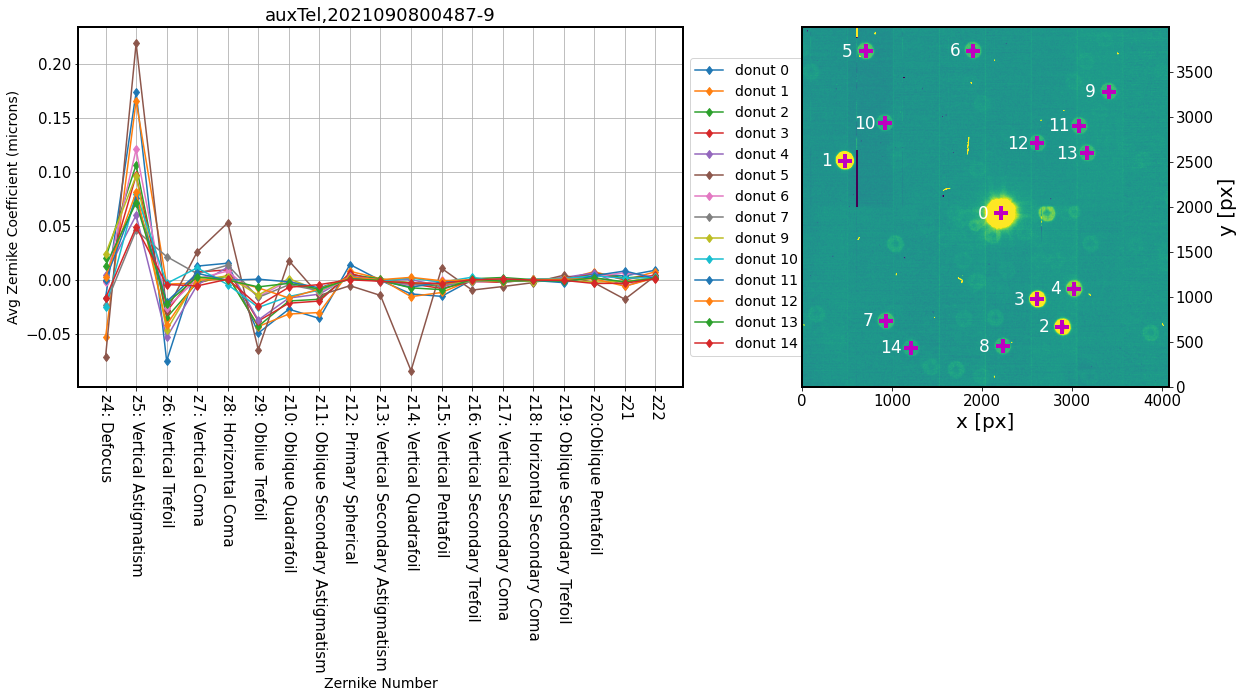

In [123]:
from matplotlib import rcParams 
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18

plot_results_and_image(exposure_extra.image.array, showZkByName=True)

Show the donut cutouts:

In [4]:
import numpy as np
zkResultsFile ='zerDic_auxTel_2021090800487-9.npy'
zernikeOutput = np.load(zkResultsFile, allow_pickle=True).item()

In [6]:
zernikeOutput['donutStampsExtra']

In [7]:
nrows = len(zernikeOutput['donutStampsExtra'])
fig,ax = plt.subplots(nrows,2,figsize=(2*nrows, 4*nrows))

for i in range(nrows):
    donut = zernikeOutput['donutStampsExtra'][i]
    ax[i,0].imshow(donut.stamp_im.getArrays()[0], origin='lower')
    
    donut = zernikeOutput['donutStampsIntra'][i]
    ax[i,1].imshow(donut.stamp_im.getArrays()[0], origin='lower')
    ax[i,0].set_title(f'Donut {i}')
ax[0,0].set_title('Extra')
ax[0,1].set_title('Intra')

NameError: name 'plt' is not defined

Next: Incorporate this code to the `ts_wep` task